In [1]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

%matplotlib inline
import itertools

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
data_folder = '../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])


print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

(999, 72, 84)
(999, 72, 32)


Shape of regular image is:  (999, 72, 32)
Shape of dead image is:  (999, 72, 32)
Shape of hot image is:  (999, 72, 32)



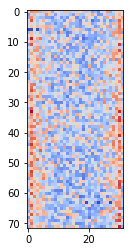

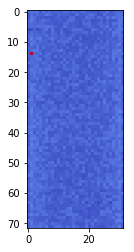

In [3]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    a=np.random.randint(input_images.shape[2]-1)
    b=np.random.randint(input_images.shape[1]-1)

    xdim=(a,a+1)
    ydim=(b,b+1)
   
    hotregion_image.append( u.hotregion(k,xdim,ydim))
    deadregion_image.append(u.killregion(k,xdim,ydim))
       
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.show()
plt.clf()


im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


If you want to see the group of images

In [4]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape

(2997, 72, 32)



For CNN

create the corresponding label matrices


In [5]:
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))


In [6]:
#this is because I am only going to add the hot and dead region images

for i in range(2,0,-1):
    y[-i*input_images.shape[0]:]=3-i
#if you want it as intergers leave this as it is
#if you would like it as a vector then do this
y=to_categorical(y,3)

In [7]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

X shape is:  (2997, 72, 32)
y shape is:  (2997, 3)


Xtrain.shape (1798, 72, 32)
Xtest.shape (1199, 72, 32)
ytrain.shape (1798, 3)
ytest.shape (1199, 3)
Printing labels and their corresponding images
-------------------
[ 0.  1.  0.]


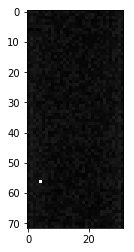

-------------------
[ 0.  1.  0.]


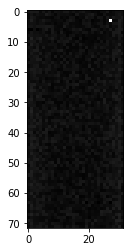

-------------------
[ 1.  0.  0.]


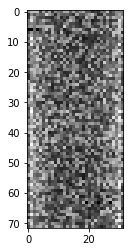

-------------------
[ 0.  1.  0.]


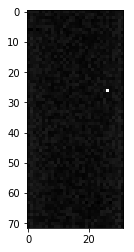

-------------------
[ 1.  0.  0.]


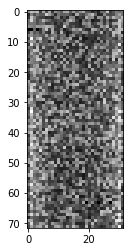

-------------------
[ 1.  0.  0.]


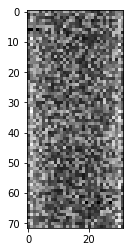

-------------------
[ 1.  0.  0.]


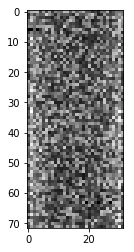

-------------------
[ 0.  0.  1.]


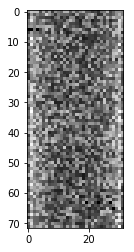

-------------------
[ 0.  1.  0.]


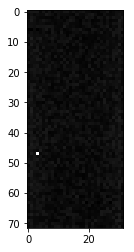

-------------------
[ 0.  1.  0.]


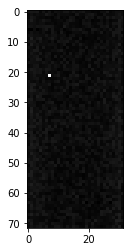

Xtrain.shape after if statement (1798, 72, 32, 1)
Xtest.shape after if statement (1199, 72, 32, 1)
ytrain.shape after if statement (1798, 3)
ytest.shape after if statement (1199, 3)


In [8]:

Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.gray)
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    


# Creating the model

In [9]:
# this is the dummy model
model = Sequential([
Conv2D(10, kernel_size=(2, 2), activation='relu', strides=(1, 1),input_shape=input_shape),
MaxPooling2D(pool_size=(2,2)),
BatchNormalization(),
Conv2D(8, kernel_size=(3, 3), activation='relu', strides=(1, 1)),
MaxPooling2D(pool_size=(2,2)),
BatchNormalization(),
Conv2D(8,kernel_size=(1,1), activation='relu'),
Dropout(0.25),
Flatten(),

Dense(8,activation='relu'),
Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',#Adam(lr=1e-3),
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 71, 31, 10)        50        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 15, 10)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 15, 10)        40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 13, 8)         728       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 6, 8)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 6, 8)          32        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 6, 8)          72        
__________

In [14]:
model.save('emptymodel.hdf5')

In [15]:
ypred=model.predict(Xtest)
ypredproba=model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

In [16]:
print ytestclass[40:50],'\n\n\n', ypredclass[40:50]

[[0]
 [1]
 [0]
 [0]
 [2]
 [0]
 [1]
 [1]
 [1]
 [2]] 


[[2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]]


0.367806505421
Confusion matrix, without normalization
[[  0   0 403]
 [  0  45 355]
 [  0   0 396]]


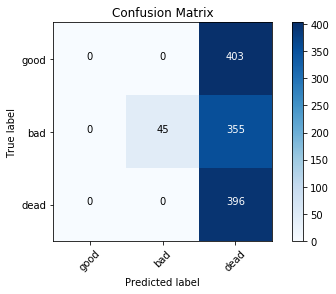

In [17]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
print metrics.accuracy_score(ytestclass,ypredclass)
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['good','bad','dead']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')

0.5 For the label #0
0.598889236546 For the label #1
0.53300124533 For the label #2


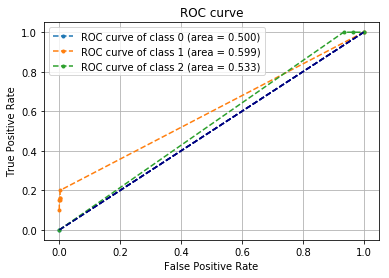

In [18]:
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = %0.3f)'.format(i) % roc_auc,marker='.')#, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
 

# Loading and Evaluation of a trained model

In [ ]:
best_model= load_model('best_trained_model_good_hot_dead.hdf5',compile=False)

In [ ]:
ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

In [ ]:
np.all(ypredproba==ypred)
#this confirms my suspicions

In [ ]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['good','bad','dead']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(ytestclass,ypredclass)


In [ ]:
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='.')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
 